https://skillbox.ru/media/code/kak-iskusstvennyy-immunitet-schitaet-vagony-i-upravlyaet-samolyetami/

https://ru.wikipedia.org/wiki/Искусственная_иммунная_система

формула аффинности была взята с https://github.com/AghilesAzzoug/Artificial-Immune-System?tab=readme-ov-file (там есть ссылка на статью, которая использовалась, https://www.researchgate.net/publication/228811231_Artificial_Immune_Recognition_System_AIRS_Revisions_and_Refinements)

Антитела — белки, которые вырабатывают иммунные клетки (лимфоциты). Их задача — распознавать и бороться с чужеродными организмами, когда те проникают в тело.
Антигены — вещества, в ответ на которые вырабатываются антитела. Они есть в опасных бактериях и вирусах (их ещё называют патогенами).
Антитела химически связываются с антигенами (прилипают к ним). Но у антител есть специфичность — они умеют прилипать только к одному виду антигенов.

1.   Шаг 1. Инициализация
      Создаём начальную популяцию антител.
2.    Шаг 2. Вычисление аффинности и отбор
      Для каждого антитела вычисляем его аффинность к антигену.
      Выбираем часть самых эффективных антител, остальные удаляем.
      Результаты записываем в массив.
3.    Шаг 3. Клонирование антител
Генерируем копии антител пропорционально их аффинности.
Чем выше аффинность, тем больше создаётся клонов, и наоборот.
4.    Шаг 4. Модификация антител
Подвергаем копии антител случайным изменениям с вероятностью, обратно пропорциональной их аффинности.
Чем ниже аффинность, тем выше вероятность мутации.
 Возврат к шагу 2
      Повторяем процесс до тех пор, пока не достигнут критерий остановки.
5.     Шаг 5. Сохранение в клетках памяти

Сохраняем лучшие антитела в памяти компьютера.


In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import datasets

In [ ]:
def show(x_label, y_label, ais, X, iris_df):
  disp = DecisionBoundaryDisplay.from_estimator(
      ais, X, response_method="predict",
      xlabel=x_label, ylabel=y_label,
      alpha=0.5,
  )
  disp.ax_.scatter(X[:, 0], X[:, 1], c=iris_df['target'], edgecolor="k")
  plt.show()

In [ ]:
def predictions(params, exclude1, exclude2, include1, include2):
  iris = datasets.load_iris()
  iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
  iris_df['target'] = iris.target
  iris_df = iris_df.drop(iris_df[iris_df['target'] == 0].index)
  y = iris_df['target'].to_numpy()
  X = np.array(iris_df.drop([exclude1, exclude2, 'target'], axis=1))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
  ais = ArtificialImmuneSystem(population_size=params[0], selection_size=params[1], generations=params[2], X=X_train)
  ais.fit(X_train, y_train)
  y_pred_1 = ais.predict(X_train)
  accuracy1 = accuracy_score(y_train, y_pred_1)
  print(f"Accuracy train: {accuracy1 * 100} %")

  y_pred = ais.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy test: {accuracy * 100} %")
  print(f"For params: population_size = {params[0]} selection_size = {params[1]} generations = {params[2]}")
  show(include1, include1, ais, X, iris_df)

In [ ]:
class ArtificialImmuneSystem(BaseEstimator, ClassifierMixin):
  def __init__(self, population_size=50, selection_size=10, generations=100, X=[]):
    self.population_size = population_size
    self.selection_size = selection_size
    self.generations = generations
    self.population = [X[random.randint(0, len(X) - 1)] for _ in range(population_size)]

  # Affinity Measure: Euclidean distance
  def affinity(self, antibody, antigen):
    squared_diff = (antibody - antigen) ** 2
    return np.sum(squared_diff)

  # Mutation operator
  def mutate(self, antibody, affinity_score):
    mutation_rate = 1 / (affinity_score + 1)  # Update mutation_rate inversely proportional to affinity_score
    mutated_antibody = antibody + np.random.normal(0, mutation_rate, size=len(antibody))
    return mutated_antibody

  def all_affinities(self, antibodies, antigen):
    affinities = []
    for antibody in antibodies:
      affinity_score = self.affinity(antibody, antigen)
      affinity_tuple = (affinity_score, antibody)
      affinities.append(affinity_tuple)
    return affinities

    # Cloning operator
  def clone_antibodies(self, affinity_tuple):
    cloned_antibodies = []
    for affinity, antibody in affinity_tuple:
      num_clones = int(affinity + 1)  # Number of clones proportional to affinity
      cloned_antibodies.extend([(affinity, antibody.copy()) for _ in range(num_clones)])
    return cloned_antibodies

  def select_top_antibodies(self, affinities):
    sorted_affinities = sorted(affinities, key=lambda x: x[0])
    top_antibodies = []
    for affinity, antibody in sorted_affinities[:self.selection_size]:
      top_antibodies.append(antibody)
    return top_antibodies

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

    for epoch in range(self.generations):
      for antigen, label in zip(X, y):
        affinities = self.all_affinities(self.population, antigen)
        sorted_affinities = sorted(affinities, key=lambda x: x[0])
        copied_selected_antibodies = self.clone_antibodies(sorted_affinities[:self.selection_size])
        mutated = [self.mutate(antibody, score) for score, antibody in copied_selected_antibodies[:self.selection_size]]
        self.population.extend(mutated)
        self.population = self.select_top_antibodies(affinities)
    self.fitted_ = True

  def predict(self, X):
    labels = []
    for data in X:
      affinities = self.all_affinities(self.population, data)
      closest_antibody = min(affinities, key=lambda a: a[0])[1]
      distances = [self.affinity(closest_antibody, self.X_train[i]) for i in range(len(self.X_train))]
      closest_train_index = np.argmin(distances)
      label = self.y_train[closest_train_index]
      labels.append(label)
    return np.array(labels)

In [ ]:
population_size = [i for i in range(50, 151, 50)]
selection_size = [i for i in range(5, 26, 10)]
generations = [i for i in range(50, 251, 50)]

params = {
    'population_size': population_size,
    'selection_size': selection_size,
    'generations': generations
}

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 50


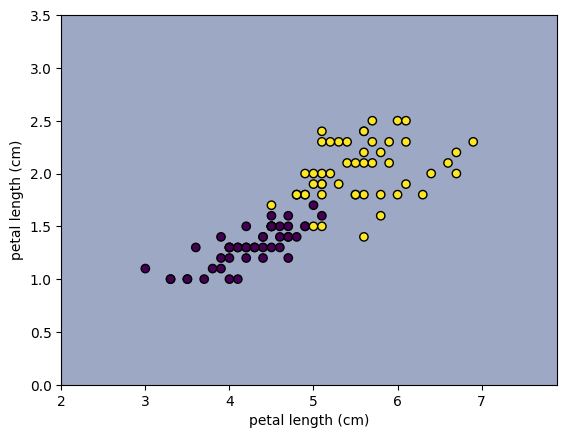

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 100


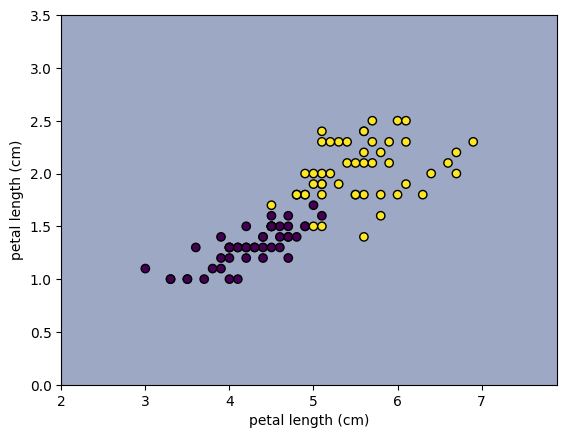

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 150


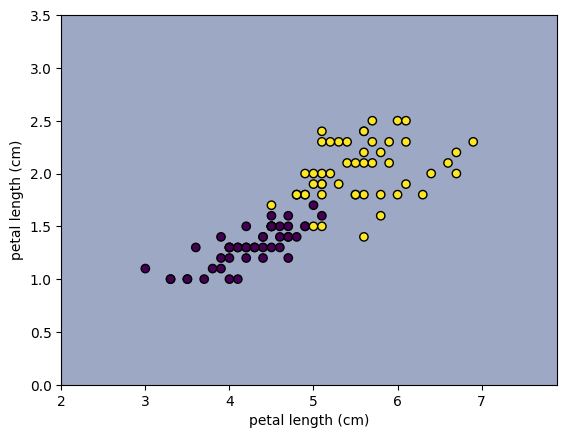

Accuracy train: 81.11111111111111 %
Accuracy test: 70.0 %
For params: population_size = 50 selection_size = 5 generations = 200


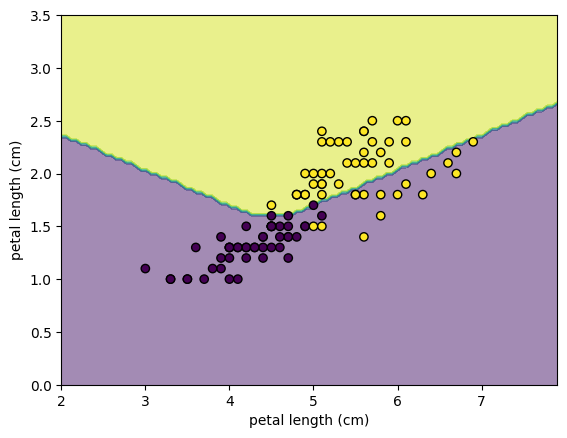

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 250


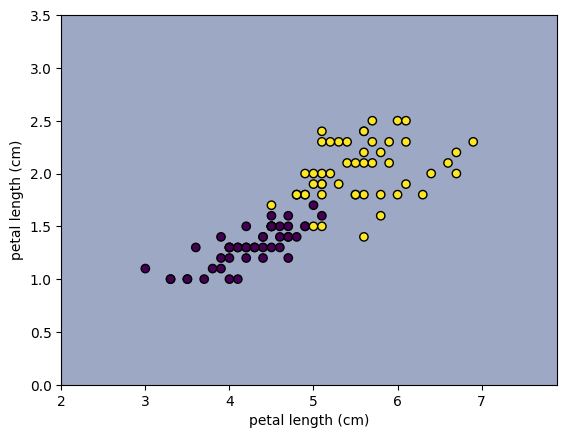

Accuracy train: 94.44444444444444 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 15 generations = 50


KeyboardInterrupt: 

In [ ]:
for population_size in params['population_size']:
  for selection_size in params['selection_size']:
    for generations in params['generations']:
      curr_params = (population_size, selection_size, generations)
      predictions(curr_params, 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)')

Accuracy train: 60.0 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 50


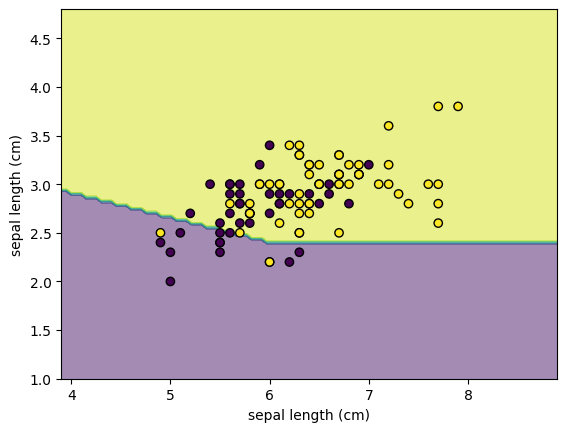

Accuracy train: 51.11111111111111 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 100


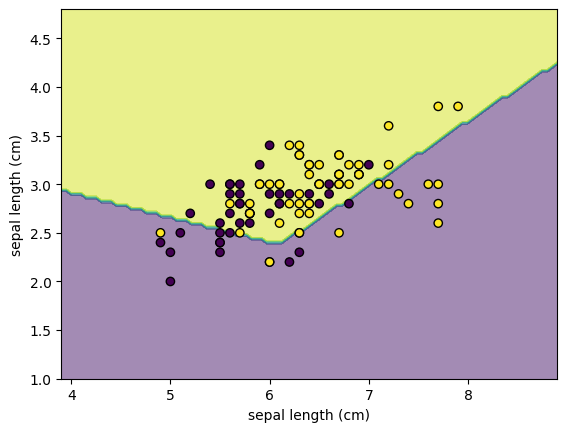

Accuracy train: 53.333333333333336 %
Accuracy test: 40.0 %
For params: population_size = 50 selection_size = 5 generations = 150


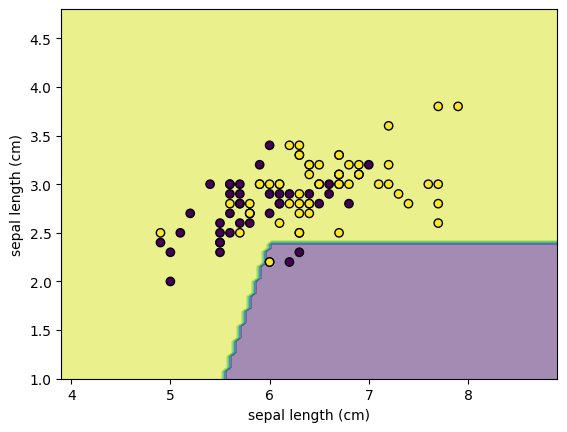

Accuracy train: 65.55555555555556 %
Accuracy test: 70.0 %
For params: population_size = 50 selection_size = 5 generations = 200


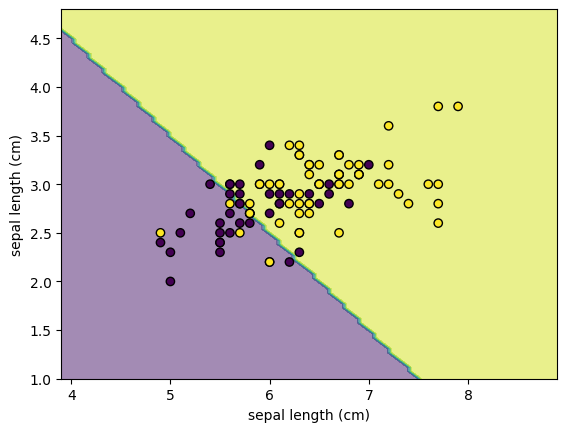

Accuracy train: 73.33333333333333 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 5 generations = 250


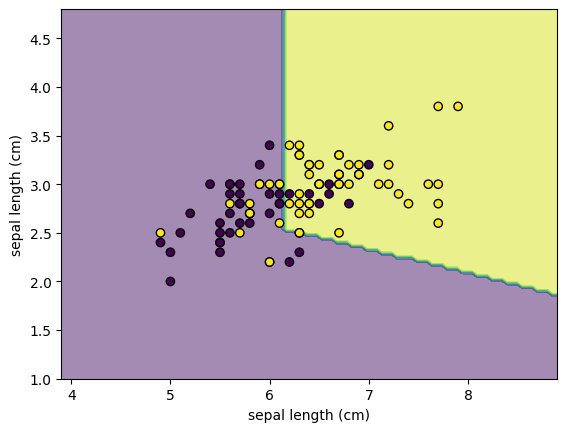

Accuracy train: 74.44444444444444 %
Accuracy test: 80.0 %
For params: population_size = 50 selection_size = 15 generations = 50


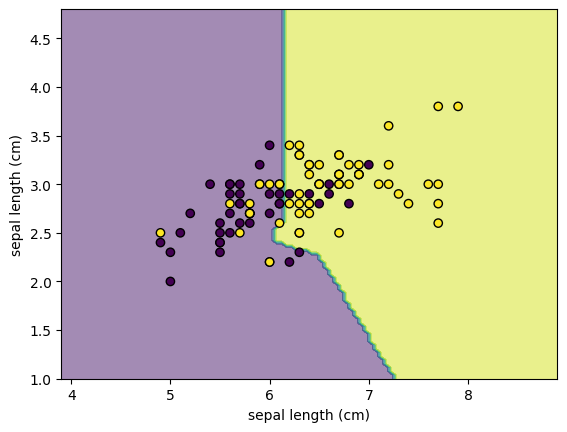

Accuracy train: 74.44444444444444 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 15 generations = 100


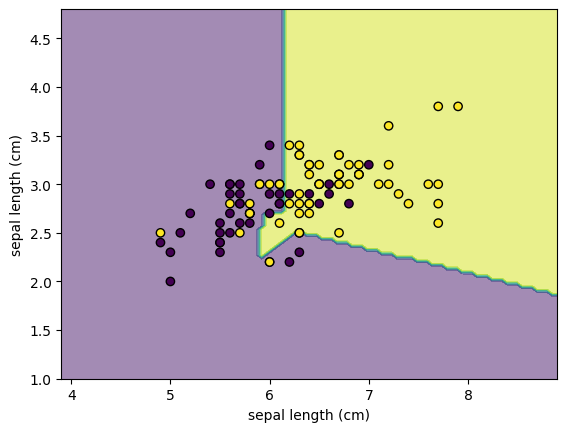

Accuracy train: 61.111111111111114 %
Accuracy test: 80.0 %
For params: population_size = 50 selection_size = 15 generations = 150


KeyboardInterrupt: 

In [ ]:
for population_size in params['population_size']:
  for selection_size in params['selection_size']:
    for generations in params['generations']:
      curr_params = (population_size, selection_size, generations)
      predictions(curr_params, 'petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)')

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 50


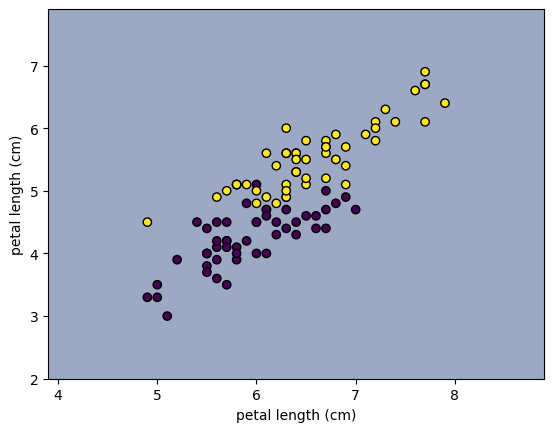

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 100


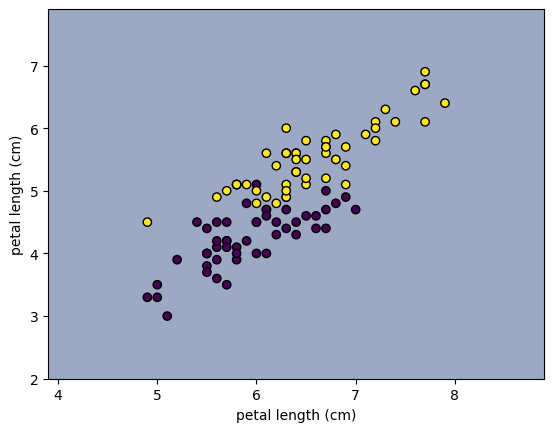

Accuracy train: 92.22222222222223 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 5 generations = 150


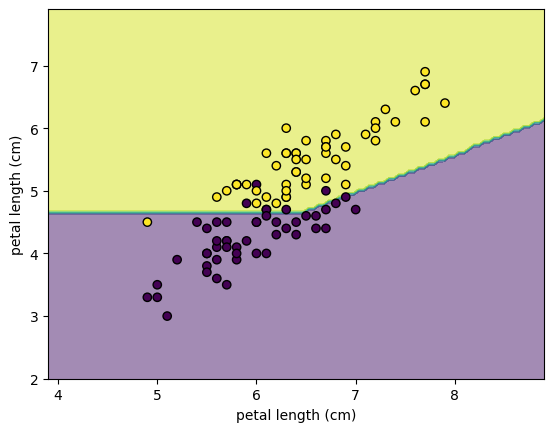

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 200


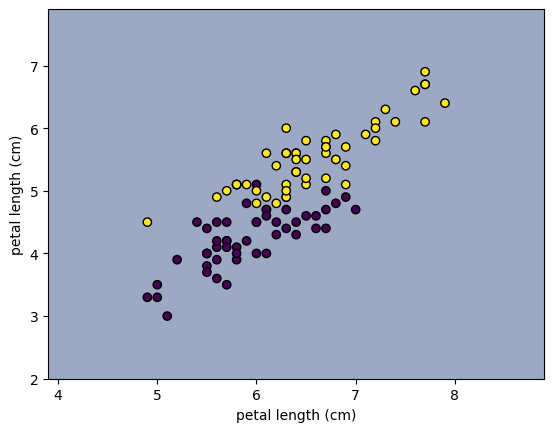

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 50 selection_size = 5 generations = 250


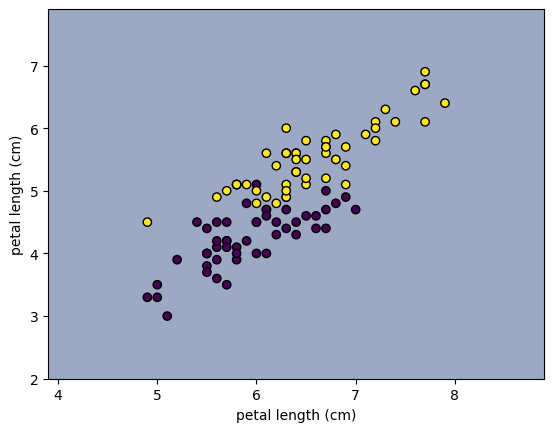

Accuracy train: 94.44444444444444 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 15 generations = 50


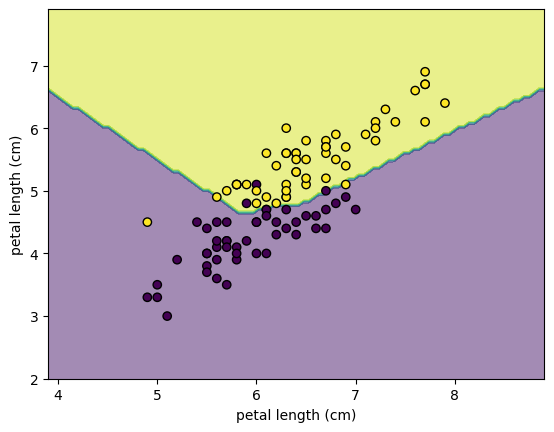

Accuracy train: 92.22222222222223 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 15 generations = 100


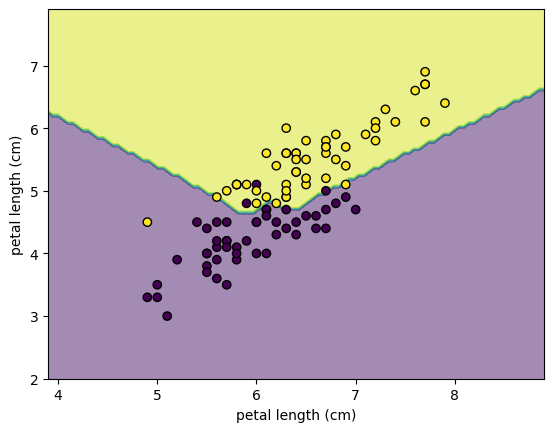

Accuracy train: 77.77777777777779 %
Accuracy test: 70.0 %
For params: population_size = 50 selection_size = 15 generations = 150


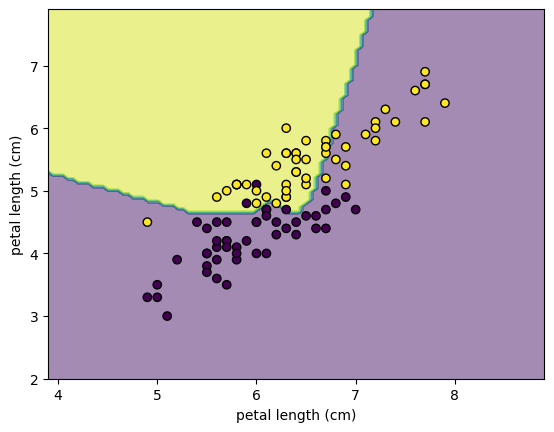

Accuracy train: 91.11111111111111 %
Accuracy test: 80.0 %
For params: population_size = 50 selection_size = 15 generations = 200


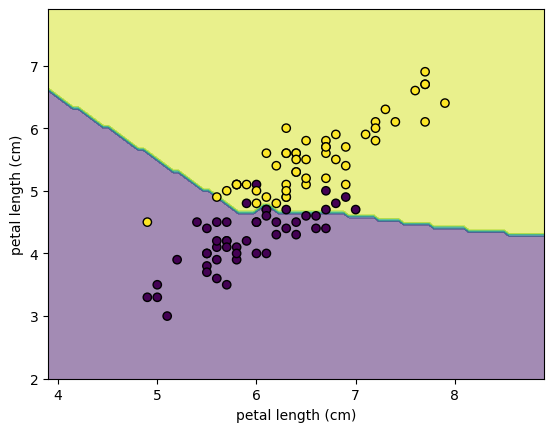

Accuracy train: 87.77777777777777 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 15 generations = 250


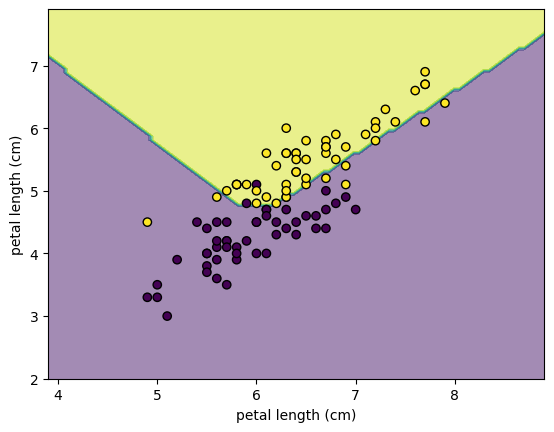

Accuracy train: 94.44444444444444 %
Accuracy test: 90.0 %
For params: population_size = 50 selection_size = 25 generations = 50


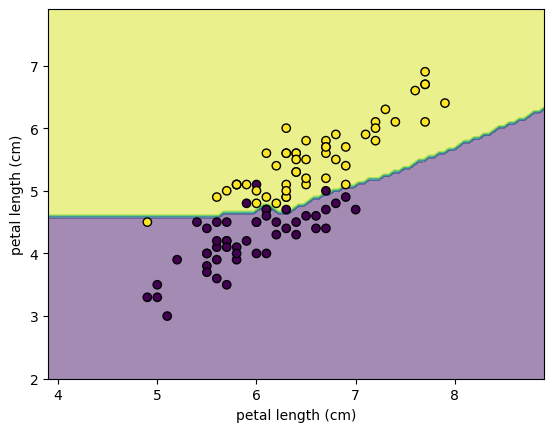

Accuracy train: 87.77777777777777 %
Accuracy test: 100.0 %
For params: population_size = 50 selection_size = 25 generations = 100


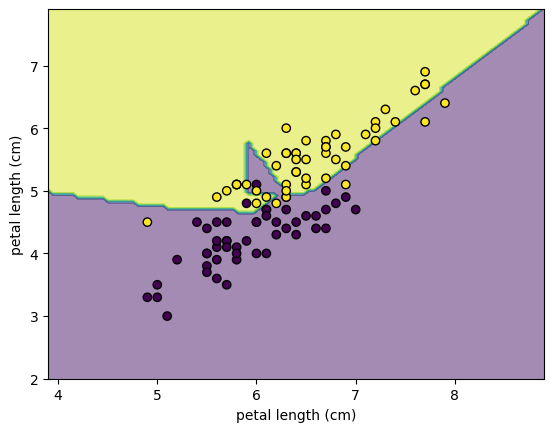

Accuracy train: 91.11111111111111 %
Accuracy test: 100.0 %
For params: population_size = 50 selection_size = 25 generations = 150


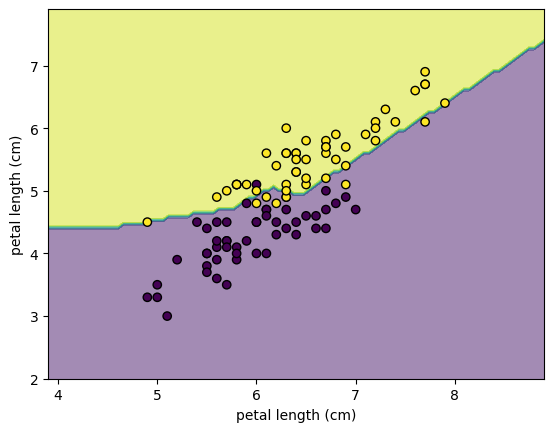

Accuracy train: 60.0 %
Accuracy test: 50.0 %
For params: population_size = 50 selection_size = 25 generations = 200


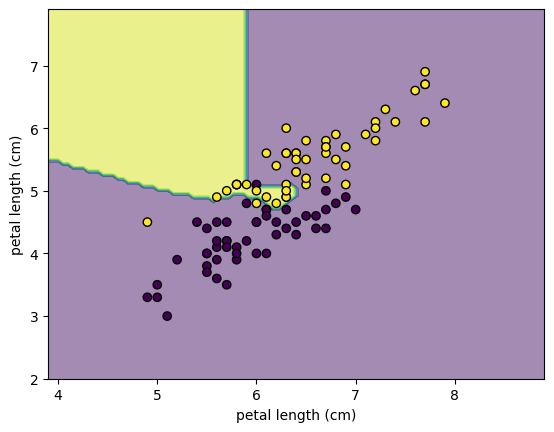

Accuracy train: 63.33333333333333 %
Accuracy test: 70.0 %
For params: population_size = 50 selection_size = 25 generations = 250


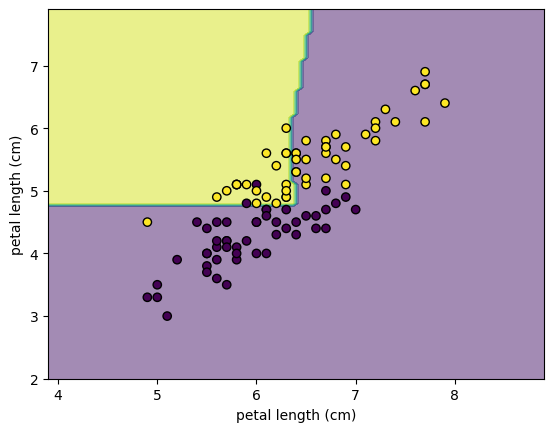

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 100 selection_size = 5 generations = 50


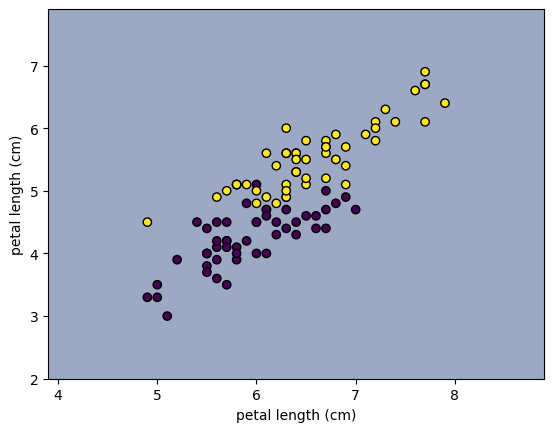

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 100 selection_size = 5 generations = 100


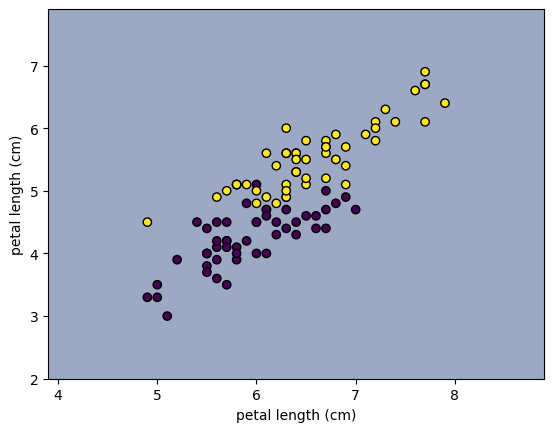

Accuracy train: 48.888888888888886 %
Accuracy test: 60.0 %
For params: population_size = 100 selection_size = 5 generations = 150


KeyboardInterrupt: 

In [ ]:
for population_size in params['population_size']:
  for selection_size in params['selection_size']:
    for generations in params['generations']:
      curr_params = (population_size, selection_size, generations)
      predictions(curr_params, 'petal width (cm)', 'sepal width (cm)', 'petal length (cm)', 'sepal length (cm)')

Accuracy: 80.0 %
For params: population_size = 50 selection_size = 5 generations = 50


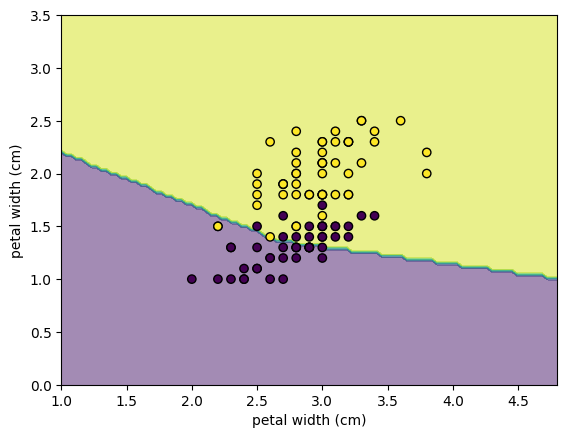

Accuracy: 50.0 %
For params: population_size = 50 selection_size = 5 generations = 100


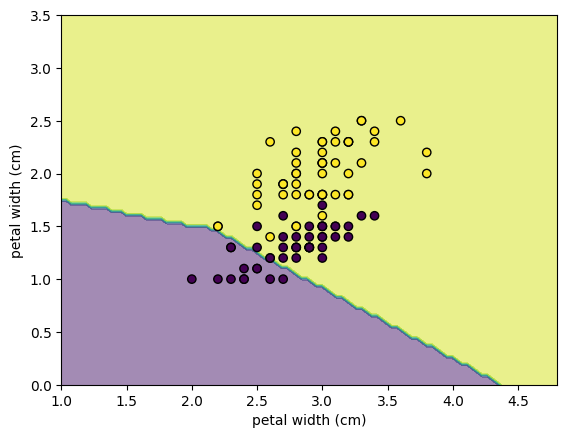

Accuracy: 90.0 %
For params: population_size = 50 selection_size = 5 generations = 150


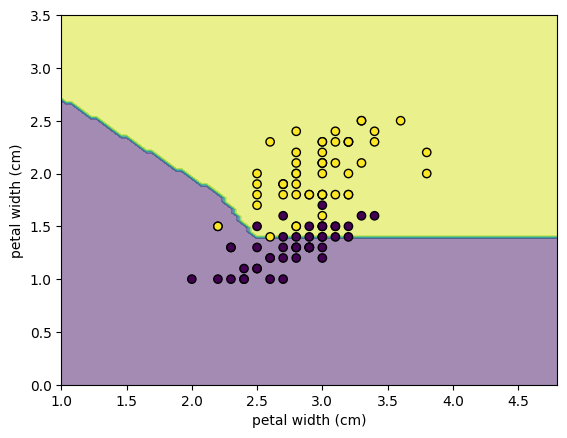

Accuracy: 90.0 %
For params: population_size = 50 selection_size = 5 generations = 200


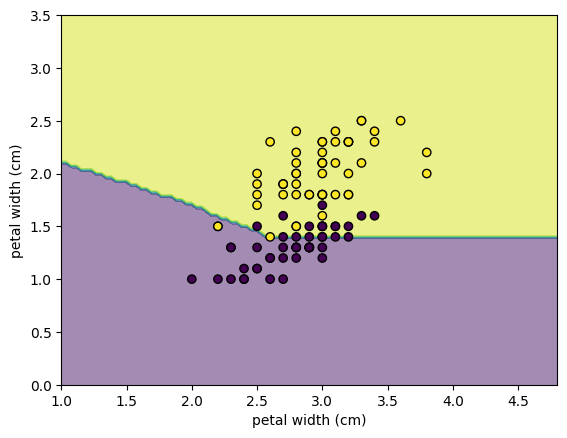

Accuracy: 90.0 %
For params: population_size = 50 selection_size = 5 generations = 250


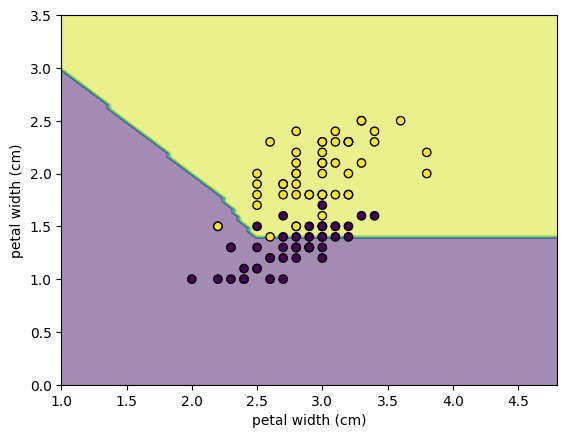

Accuracy: 90.0 %
For params: population_size = 50 selection_size = 15 generations = 50


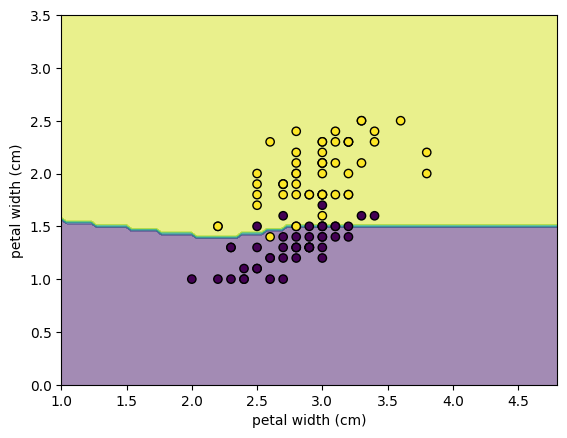

Accuracy: 80.0 %
For params: population_size = 50 selection_size = 15 generations = 100


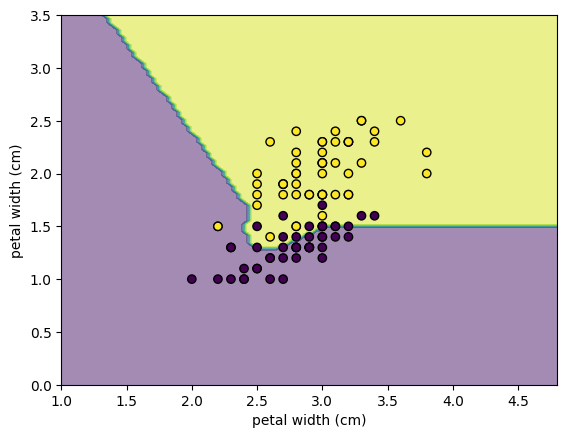

Accuracy: 60.0 %
For params: population_size = 50 selection_size = 15 generations = 150


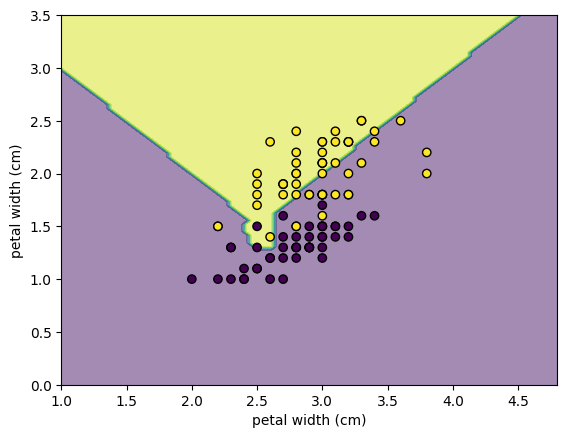

Accuracy: 50.0 %
For params: population_size = 50 selection_size = 15 generations = 200


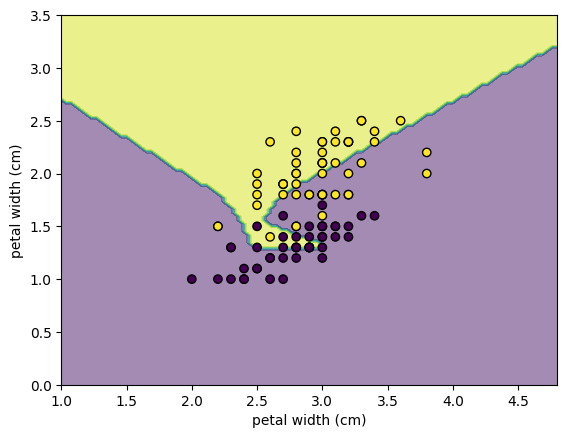

Accuracy: 70.0 %
For params: population_size = 50 selection_size = 15 generations = 250


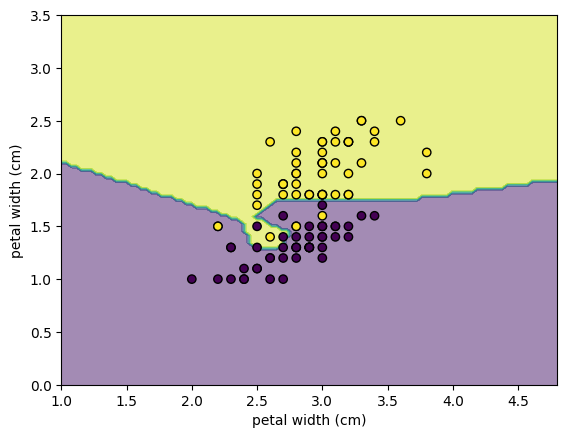

Accuracy: 80.0 %
For params: population_size = 50 selection_size = 25 generations = 50


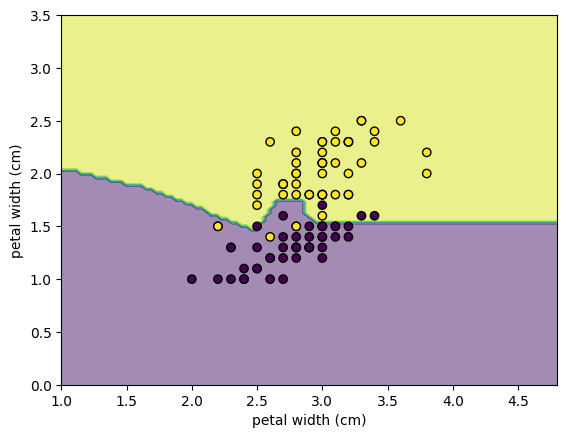

Accuracy: 90.0 %
For params: population_size = 50 selection_size = 25 generations = 100


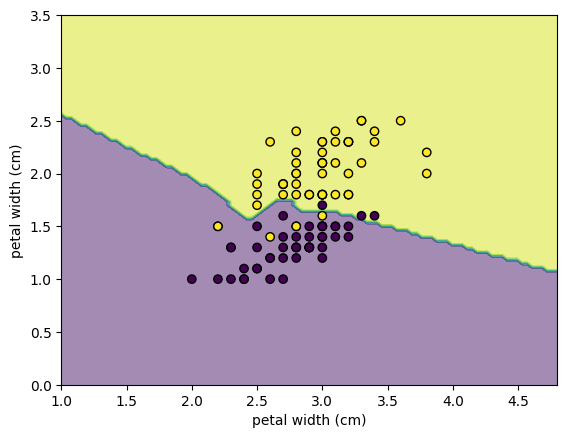

Accuracy: 70.0 %
For params: population_size = 50 selection_size = 25 generations = 150


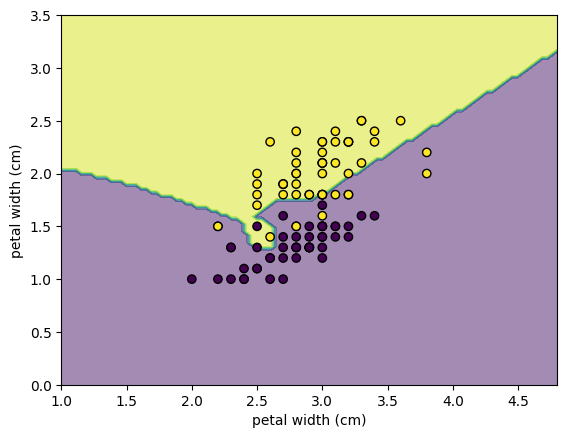

Accuracy: 60.0 %
For params: population_size = 50 selection_size = 25 generations = 200


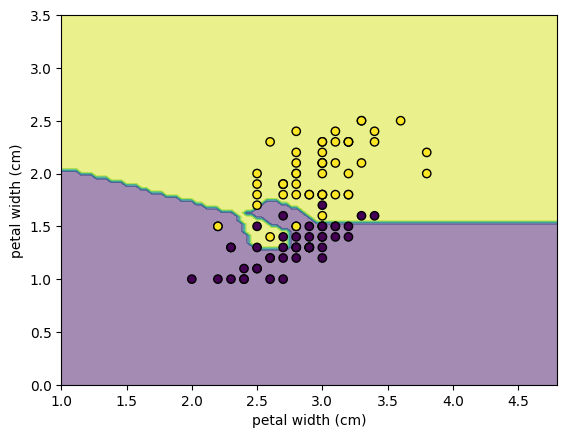

Accuracy: 70.0 %
For params: population_size = 50 selection_size = 25 generations = 250


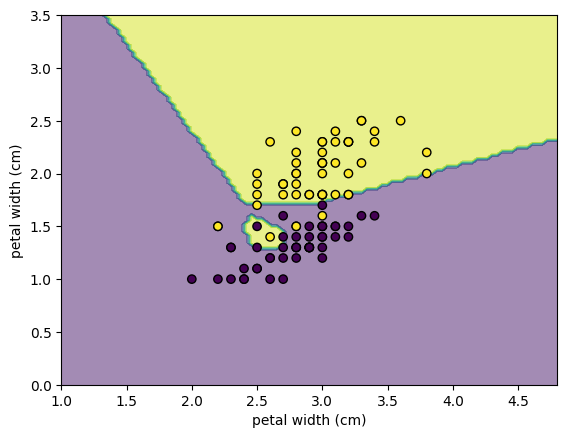

Accuracy: 60.0 %
For params: population_size = 100 selection_size = 5 generations = 50


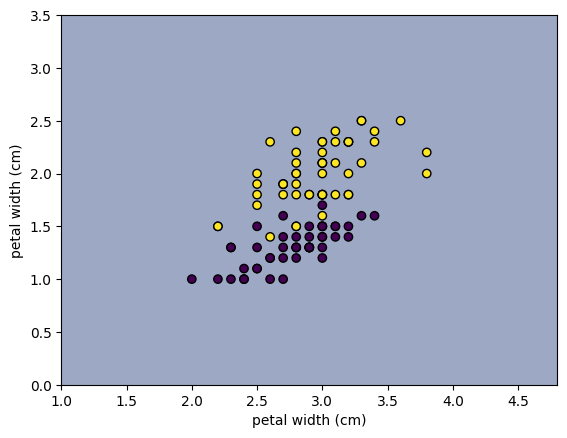

Accuracy: 60.0 %
For params: population_size = 100 selection_size = 5 generations = 100


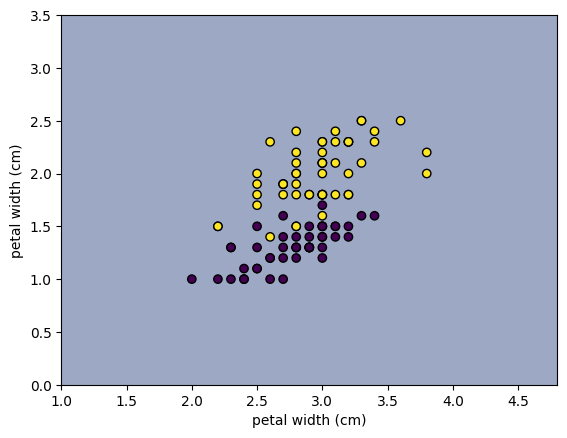

Accuracy: 100.0 %
For params: population_size = 100 selection_size = 5 generations = 150


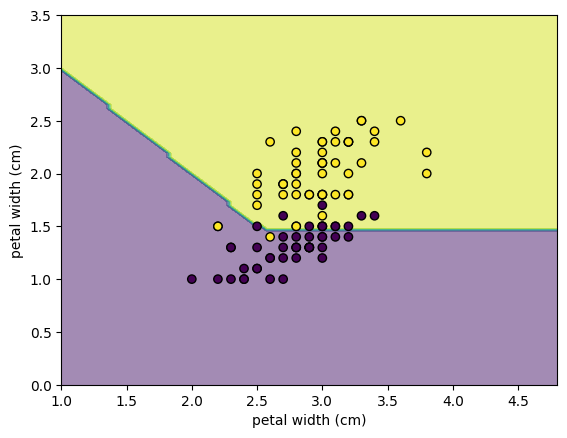

Accuracy: 60.0 %
For params: population_size = 100 selection_size = 5 generations = 200


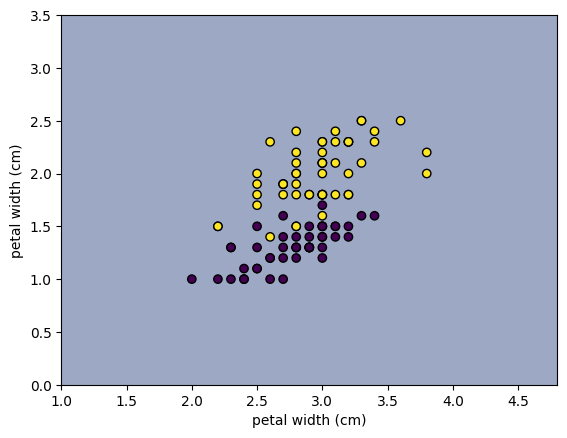

Accuracy: 60.0 %
For params: population_size = 100 selection_size = 5 generations = 250


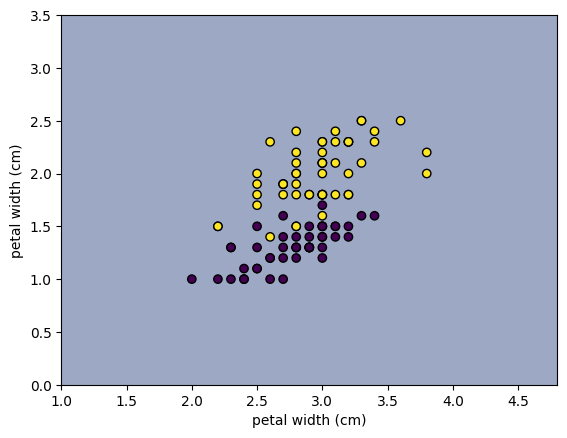

Accuracy: 50.0 %
For params: population_size = 100 selection_size = 15 generations = 50


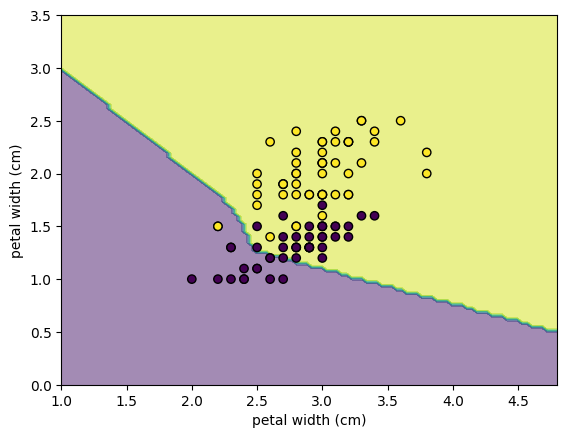

Accuracy: 50.0 %
For params: population_size = 100 selection_size = 15 generations = 100


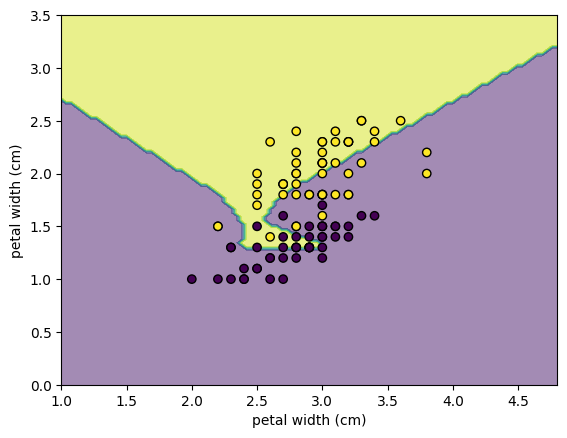

Accuracy: 60.0 %
For params: population_size = 100 selection_size = 15 generations = 150


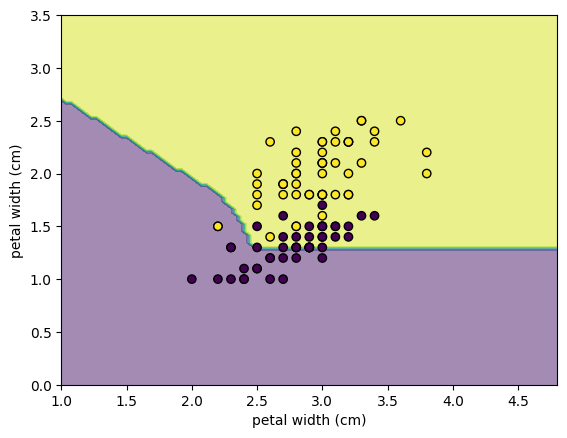

Accuracy: 60.0 %
For params: population_size = 100 selection_size = 15 generations = 200


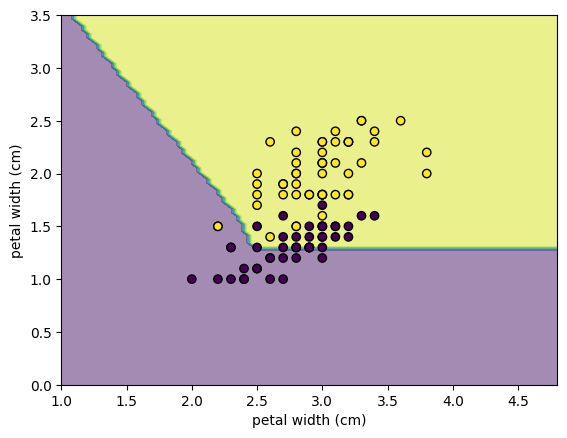

Accuracy: 50.0 %
For params: population_size = 100 selection_size = 15 generations = 250


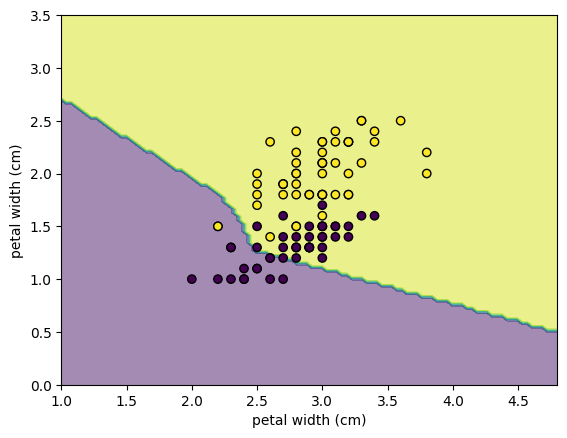

Accuracy: 70.0 %
For params: population_size = 100 selection_size = 25 generations = 50


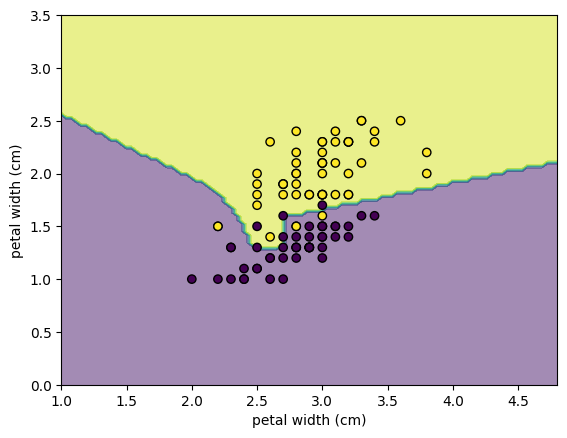

Accuracy: 70.0 %
For params: population_size = 100 selection_size = 25 generations = 100


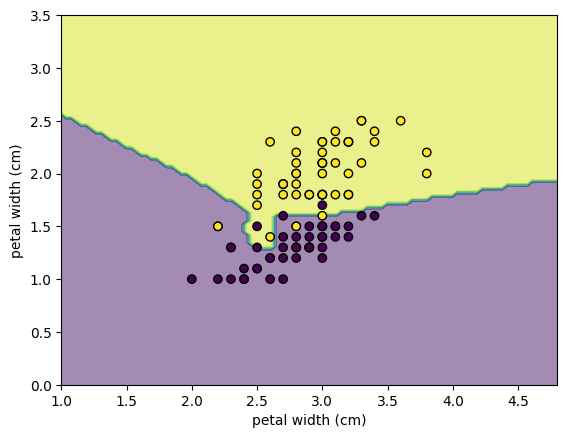

Accuracy: 70.0 %
For params: population_size = 100 selection_size = 25 generations = 150


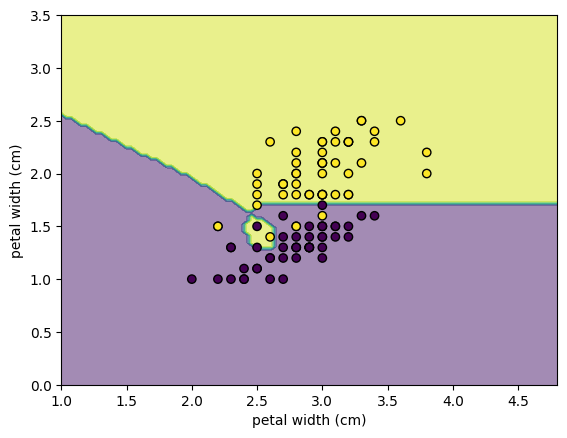

Accuracy: 90.0 %
For params: population_size = 100 selection_size = 25 generations = 200


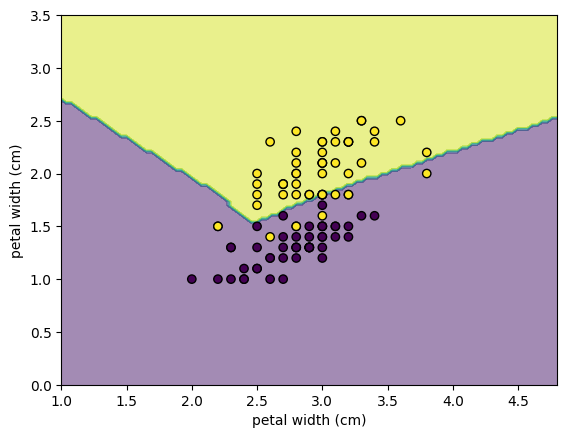

Accuracy: 70.0 %
For params: population_size = 100 selection_size = 25 generations = 250


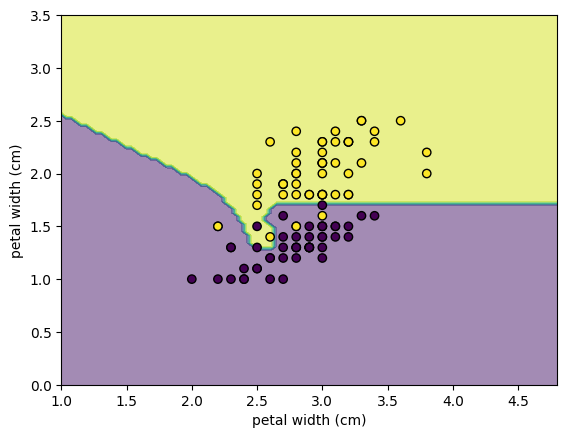

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 5 generations = 50


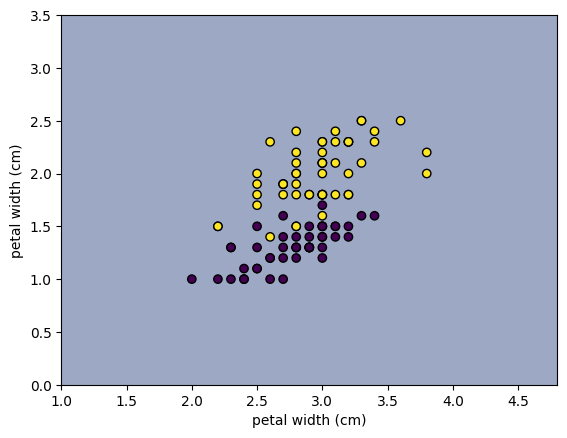

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 5 generations = 100


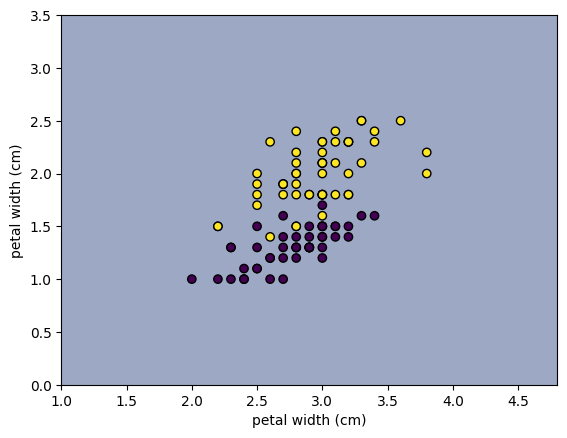

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 5 generations = 150


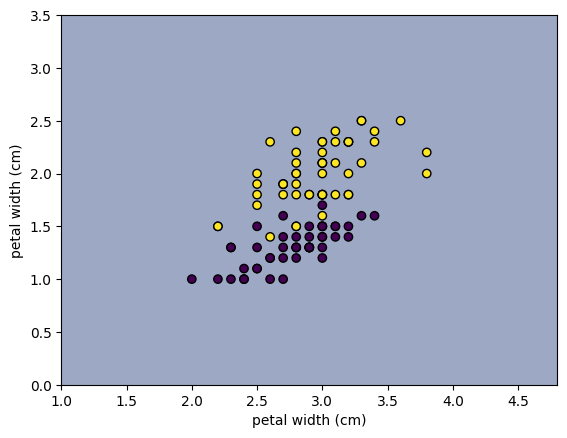

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 5 generations = 200


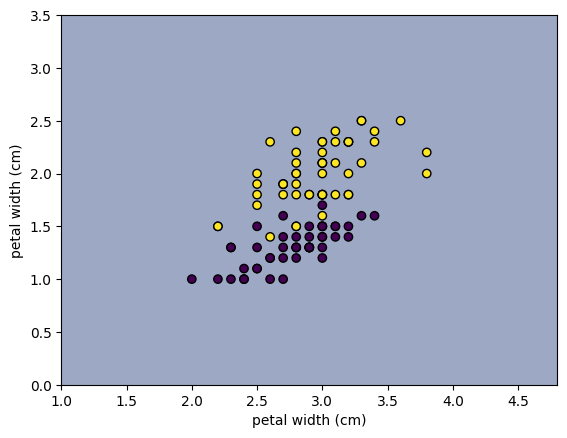

Accuracy: 90.0 %
For params: population_size = 150 selection_size = 5 generations = 250


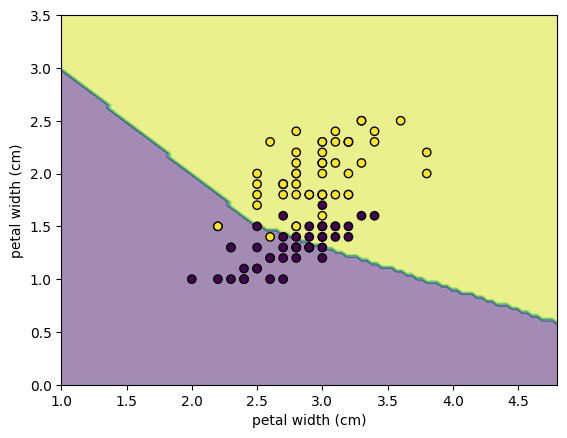

Accuracy: 80.0 %
For params: population_size = 150 selection_size = 15 generations = 50


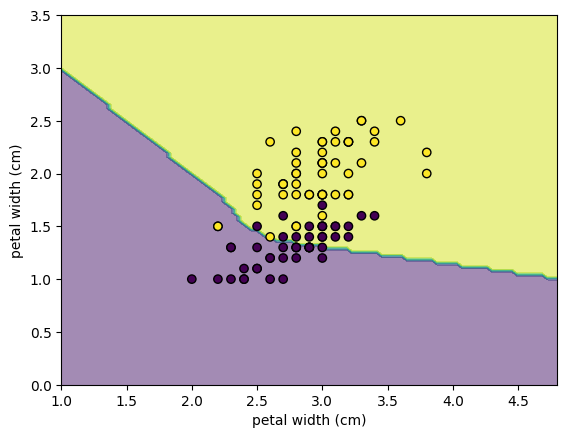

Accuracy: 90.0 %
For params: population_size = 150 selection_size = 15 generations = 100


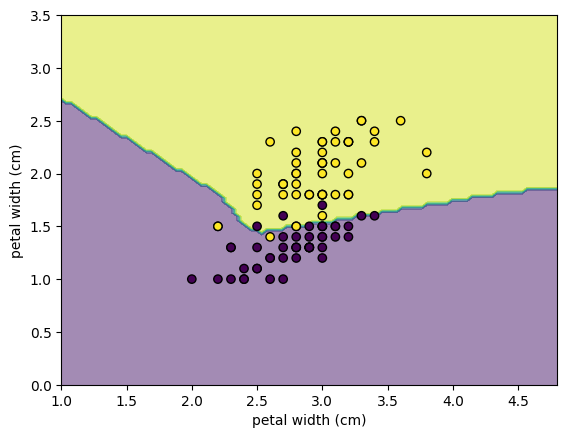

Accuracy: 50.0 %
For params: population_size = 150 selection_size = 15 generations = 150


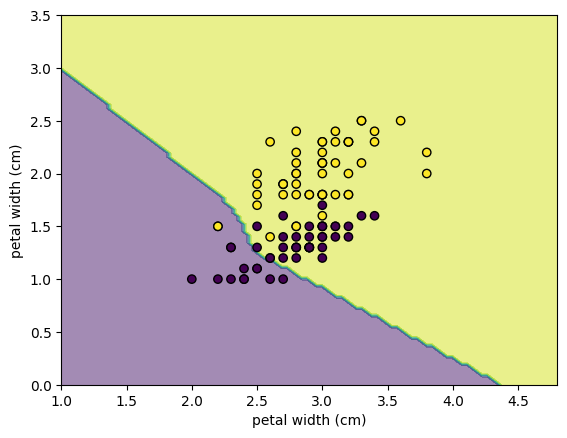

Accuracy: 50.0 %
For params: population_size = 150 selection_size = 15 generations = 200


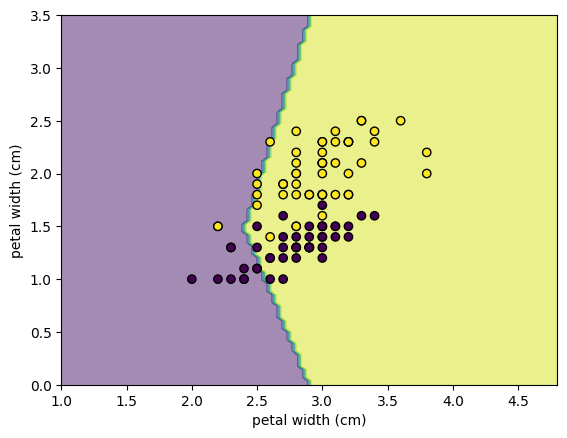

Accuracy: 50.0 %
For params: population_size = 150 selection_size = 15 generations = 250


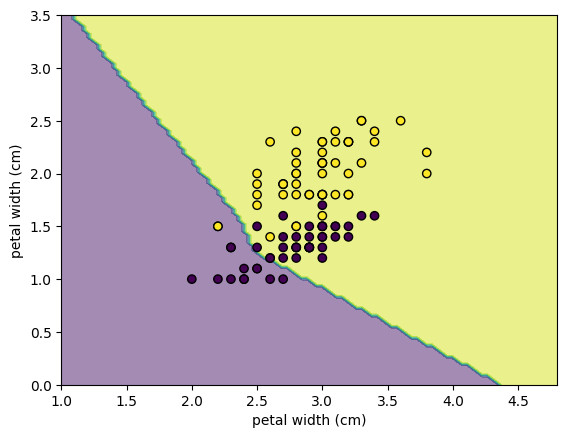

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 25 generations = 50


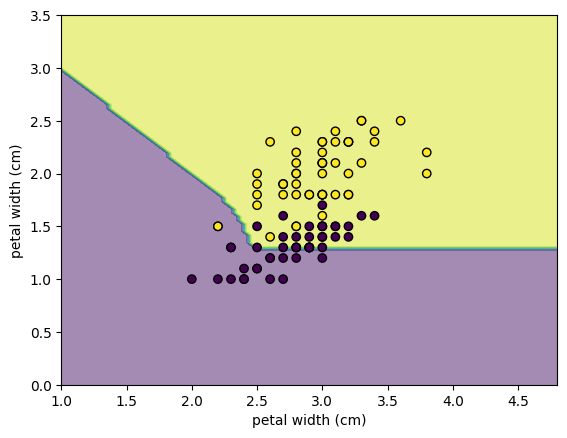

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 25 generations = 100


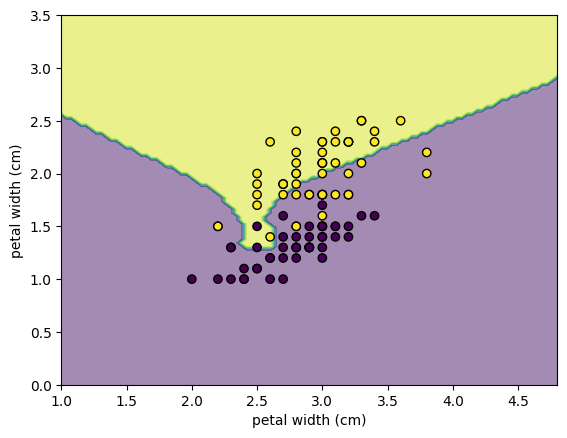

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 25 generations = 150


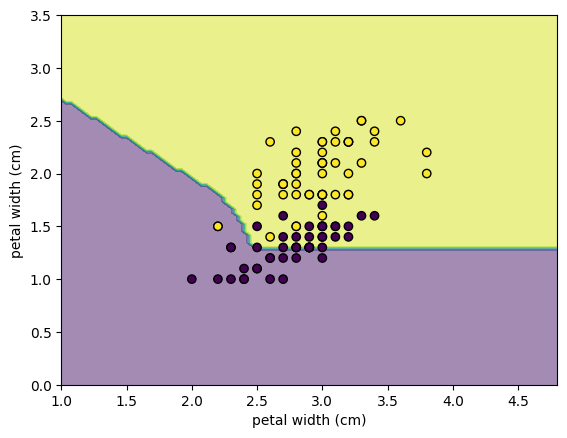

Accuracy: 90.0 %
For params: population_size = 150 selection_size = 25 generations = 200


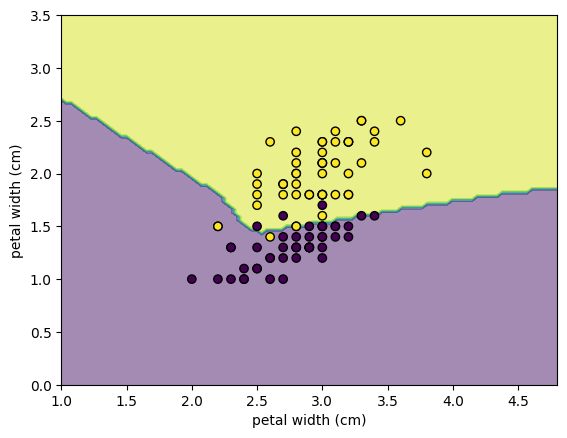

Accuracy: 60.0 %
For params: population_size = 150 selection_size = 25 generations = 250


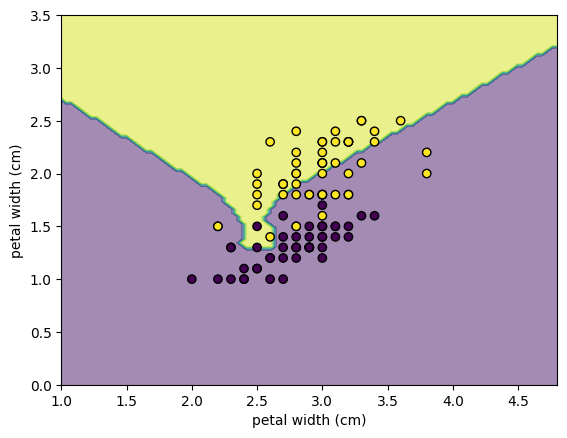

In [ ]:
for population_size in params['population_size']:
  for selection_size in params['selection_size']:
    for generations in params['generations']:
      curr_params = (population_size, selection_size, generations)
      predictions(curr_params, 'petal length (cm)', 'sepal length (cm)', 'petal width (cm)', 'sepal width (cm)')